# Ford GoBike System Data Exploration
## by Luca(MingCong) Zhou

## Preliminary Wrangling

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from geopy.distance import distance

%matplotlib inline

In [2]:
# Since GitHub does not allow for large file, I decided loading the data from an url
file_url = "https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv"
res = requests.get(file_url)

In [3]:
# load the bytes data into pandas dataframe if status code is 200
if res.status_code != requests.codes.ok:
    print("Download Failed!")

s = str(res.content, 'utf-8')
data = StringIO(s)
df = pd.read_csv(data)

In [4]:
# high-level overview of data shape and composition
df.sample()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
115644,358,2019-02-12 08:34:18.2670,2019-02-12 08:40:16.7510,345.0,Hubbell St at 16th St,37.766483,-122.398279,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,643,Subscriber,NaN,NaN,No


In [5]:
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())

(183412, 16)
duration_sec                 int64
start_time                  object
end_time                    object
start_station_id           float64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
bike_share_for_all_trip     object
dtype: object
duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                    

### Issues

#### Issue 1 Missing Values

1. 197 values are missing for features: start_station_id, start_station_name.
2. 8265 values are missing for features: member_birth_year and member_gender.

#### Solve Issue 1

In [6]:
# drop the rows with null values
df.dropna(inplace=True)

#### Issue 2 Misused Data Types

1. start_time, and end_time columns are in string format.
2. start_station_id, and member_birth_year columns are in float format.

#### Solve Issue 2

In [7]:
# convert the 'start_time' and 'end_time' columns to datetime format
df['start_time']= pd.to_datetime(df['start_time'])
df['end_time']= pd.to_datetime(df['end_time'])

# convert the 'start_station_id' and 'member_birth_year columns to int format
df['start_station_id'] = df['start_station_id'].astype('int')
df['member_birth_year'] = df['member_birth_year'].astype('int')

#### Inspect the cleaned dataframe

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174952 non-null  int64         
 1   start_time               174952 non-null  datetime64[ns]
 2   end_time                 174952 non-null  datetime64[ns]
 3   start_station_id         174952 non-null  int64         
 4   start_station_name       174952 non-null  object        
 5   start_station_latitude   174952 non-null  float64       
 6   start_station_longitude  174952 non-null  float64       
 7   end_station_id           174952 non-null  float64       
 8   end_station_name         174952 non-null  object        
 9   end_station_latitude     174952 non-null  float64       
 10  end_station_longitude    174952 non-null  float64       
 11  bike_id                  174952 non-null  int64         
 12  user_type       

### What is the structure of your dataset?

There are 183412 rides in the dataset with 16 features (``duration_sec``, ``start_time``, ``end_time``, ``start_station_id``, ``start_station_name``, ``start_station_latitude``, ``start_station_longitude``, ``end_station_id``, ``end_station_name``, ``end_station_latitude``, ``end_station_longitude``, ``bike_id``, ``user_type``, ``member_birth_year``, ``member_gender``, and ``bike_share_for_all_trip``). 

Most variables are numeric in nature, but the variables ``start_station_name``, ``end_station_name``, ``user_type``, ``member_gender`` and ``bike_share_for_all_trip`` are nominal factor variables.

### What is/are the main feature(s) of interest in your dataset?

I'm most interested in figuring out:

1. How far do people usually bike when they are using our shared bicycles?
2. How long does the average trip take?
3. When are most trips taken in terms of the time of day?
4. Does the above depend on if a user is a subscriber or customer?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

1. The ``latitude`` and ``longitude`` features in the dataset can help us locate the two locations. Since they are coordinates, we can get the distance quickly by using geopy.
2. Subtract ``start_time`` with ``end_time``.
3. The ``start_time`` feature in the dataset representing the starting time. However, time can either be **categorical** or **quantitative** depending on our condition(hours, seasons, years)
4. Group by ``user_type``, and compare statistics.


## Univariate Exploration


### How far do people usually bike when they are using our shared bicycles?

To get the distance of rides, we need to know the starting and ending locations. The features ``start_station_latitude``, ``start_station_longitude``, ``end_station_latitude``, and ``end_station_longitude`` are provided in the datasets. These features are two GPS coordinates:

```text
                                        |
                                        |   (x1,y1)
                                        |
                                        |
                                        |                        (x2, y2)
                                --------|-----------------------------------------
                                        |
```

Remember, from high school, to find the distance between two coordinates, we can use [Euclid's theorem](https://en.wikipedia.org/wiki/Euclid's_theorem). Nevertheless, since Earth is a sphere, we can not merely apply the theorem here. However, Python has made everything so easy for us. We will use the [geopy](https://github.com/geopy/geopy) library to solve the problem.


In [26]:
# use geopy to measure distances, store it as a new feature
# for your reference: https://geopy.readthedocs.io/en/stable/#module-geopy.distance
def getDistance(startCoord, endCoord):
    """
    This function will return the distance (in km) between two coordinates.

    :param[float tuple] startCoord the starting coordinate
    :param[float tuple] endCoord the ending coordinate
    :return float, the distance between two coordinates
    """
    return distance(startCoord, endCoord).km

In [27]:
distances = list()

# calculate distance for all rows
for ride in df.itertuples():
    startCoord = (ride.start_station_latitude, ride.start_station_longitude)
    endCoord = (ride.end_station_latitude, ride.end_station_longitude)
    distances.append(getDistance(startCoord, endCoord))

df['distance'] = distances

Now we have the distances. Why don't we go one step further, calculate the speed? As we all know from primary school math, we can use the following formula to calculate the speed:

$$Speed = \frac{Distance}{Time}$$

The elapsed time can be retrieved by subtracting the ``start_time`` with the ``end_time`` feature. Yes, we have everything we need now.

In [101]:
def diffInHour(endTime, startTime):
    """
    Calculate the difference between two datetime object

    :param[datetime64] endTime the ending time
    :param[datetime64] startTime the starting time
    :return float, difference in hours
    """
    return (endTime - startTime) / np.timedelta64(1, "h")

In [29]:
diffs = list()

# calculate elapsed time for all rows
for ride in df.itertuples():
    diff = diffInHour(ride.end_time, ride.start_time)
    diffs.append(diff)

df['duration'] = diffs
df['speed'] = df['distance'] / df['duration']

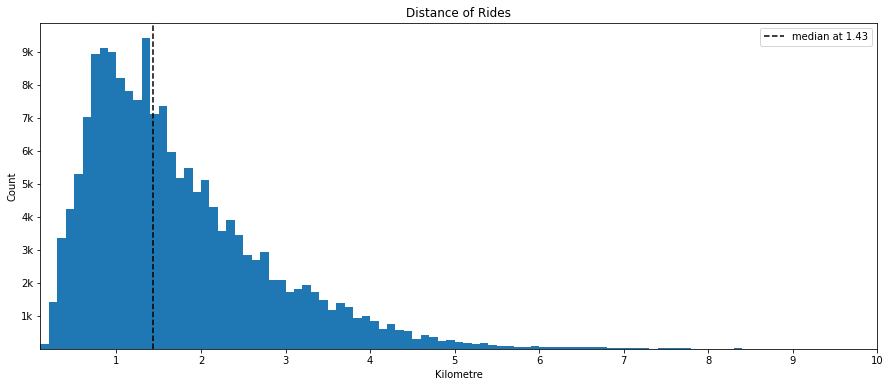

In [96]:
# start with distance
plt.figure(figsize=[15, 6])

bins = np.arange(0, 10 + 0.1, 0.1)

plt.hist(data=df, x='distance', bins= bins)


# add ticks for x axis
xticks = np.arange(0, 10 + 1, 1)
plt.xticks(xticks)

# add ticks for y axis
yticks = np.arange(1000, 10000, 1000)
ylabel = ['{}k'.format(el // 1000) for el in yticks]
plt.yticks(yticks, ylabel)

# zoom in. there are outliers in the df
plt.xlim([0.1, 10])

# add title and label
plt.title("Distance of Rides")
plt.xlabel("Kilometre")
plt.ylabel("Count")

# add a vertical line for median
med = df.distance.median()
plt.axvline(x=med, color='k', linestyle='--', label="median at {:.2f}".format(med))

plt.legend()

plt.show()

Since the ``distance`` feature is a quantitative continuous variable, a histogram can be applied for its visualization. As we can see on the above graph, there are a few peaks and valleys; Yet there are two main ones. Therefore, it is a **bimodal histogram**. 

A vertical line that represents the median has been added to the graph. The line tells us half of our users choose to use our shared bicycles when the trip is less than 1.43 kilometers. As the distance increases, the user's count using the shared bicycles gradually decreases on the vertical line's right. Therefore, the ``distance`` feature has a **right-skewed** distribution. By analogy, people tend to move out from our shared bicycles when the distance to a location is more significant than 1.43 kilometers.

During the building of the above visulization, some surprises on the dataset were found.

1. As we can see in the data frame below, this lady biked 70 kilometers in 1.93 hours. The calculated time is around 5 hours and 19 minutes on Google Map for this trip. The event should consider as a miracle for her.

In [91]:
df.query("distance >= 69")[['start_station_name', 'end_station_name', 'member_gender', 'distance', 'duration']]

,start_station_name,end_station_name,member_gender,distance,duration
112038,Montgomery St BART Station (Market St at 2nd St),Palm St at Willow St,Female,69.465977,1.929377


Since the above row's distance is a bias, the above graph has zoomed in to display most of the data points.

2. Another unique point occurs when the distance is zero. About 3.5K rides ended at the same position; The starting point is the same as the ending point. Since we cannot track the distance when the two points are the same, the above graph has set the starting ticks as 0.1 using the ``xlim`` method.

In [99]:
len(df.query("distance == 0"))

3458

Three thousand four hundred fifty-eight rows are having a distance of zero.

### When are most trips taken in terms of the time of day?

Time can either be categorical or quantitative depending on our condition(hours, seasons, and years). Since we are insterested in the time of the day, we will group time iterms of hours. 

The start_time feature in the dataset representing the starting time. However, time can either be categorical or quantitative depending on our condition(hours, seasons, years)

In [ ]:
df.s

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!